<a href="https://colab.research.google.com/github/samantamrityunjay/ICDcoding/blob/master/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re

In [3]:
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
from collections import Counter

In [4]:
import torch 
import torch.nn as nn
from torchtext import data
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
SEED = 2020
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
# random.seed(SEED)

In [10]:
diagnosis=pd.read_csv('/content/drive/MyDrive/AlgoIntern/Data/discharge_diagnosis_icd.csv')

In [11]:
diagnosis

,HADM_ID,CATEGORY,description,discharge diagnosis:,ICD9_CODE,ICD10
0,100001.0,Discharge summary,{'Report': 1},osteomyelitis bleeding duodenal ulcer heart f...,"25013,3371,5849,5780,V5867,25063,5363,4580,250...","Misc,Misc,N179,Misc,Z794,Misc,Misc,Misc,Misc,I..."
1,100009.0,Discharge summary,{'Report': 1},"r subdural hematoma, right mca stroke","41401,99604,4142,25000,27800,V8535,4148,4111,V...","I2510,Misc,Misc,E119,E669,Misc,Misc,I200,Z9861..."
2,100010.0,Discharge summary,{'Report': 1},type a aortic dissection s/p replacement of a...,"1890,1961,1987,1976,27652","Misc,Misc,Misc,Misc,E861"
3,100011.0,Discharge summary,{'Report': 1},primary diagnosis s/p pedestrian struck by ca...,"85206,82111,86403,48242,8600,2851,86121,80703,...","Misc,Misc,Misc,Misc,Misc,D62,Misc,Misc,Misc,Mi..."
4,100016.0,Discharge summary,{'Report': 1},atrial fibrillation with rapid ventricular re...,"5070,51881,51881,25541,47874,7580,34590,2512,4...","J690,J9600,J9690,Misc,Misc,Misc,Misc,Misc,I952..."
...,...,...,...,...,...,...
40473,199987.0,Discharge summary,{'Report': 1},s/p motor vehicle crash injuries: multiple le...,"8080,8604,80709,5180,5180,8082,8056,9190,E8120","Misc,Misc,Misc,J9811,J9819,Misc,Misc,Misc,Misc"
40474,199988.0,Discharge summary,{'Report': 1},1. rectal cancer. 2. status post proctocole...,"1541,99859,9974,5672,0389,5609,7070,E8792,2720","Misc,Misc,Misc,Misc,A419,Misc,Misc,Misc,E780"
40475,199992.0,Discharge summary,{'Report': 1},junctional bradycardia chronic diastolic cong...,"42789,42789,5070,5849,2760,1120,2449,0539,3272...","I498,R001,J690,N179,E870,Misc,E039,Misc,G4733,..."
40476,199998.0,Discharge summary,{'Report': 1},deceased. gastrointestinal stromal tumor. f...,"41401,9971,9971,9971,9971,9975,42731,78820,411...","I2510,I97710,I97790,I9788,I9789,Misc,I4891,Mis..."


In [12]:
diagnosis['ICD9_CODE_list']=diagnosis['ICD9_CODE'].progress_apply(lambda x: list(set(re.split(',',x))))

In [13]:
diagnosis['ICD9_CATEGORY_list']=diagnosis['ICD9_CODE_list'].progress_apply(lambda x:list(set([re.split("(\d{3}|[VE]\d{2})",i)[1] for i in x]))) # converting codes into high level category

In [14]:
diagnosis

,HADM_ID,CATEGORY,description,discharge diagnosis:,ICD9_CODE,ICD10,ICD9_CODE_list,ICD9_CATEGORY_list
0,100001.0,Discharge summary,{'Report': 1},osteomyelitis bleeding duodenal ulcer heart f...,"25013,3371,5849,5780,V5867,25063,5363,4580,250...","Misc,Misc,N179,Misc,Z794,Misc,Misc,Misc,Misc,I...","[36201, 25063, 7078, 25043, 25083, 5780, 5849,...","[337, 536, 584, V13, 458, 403, V58, 585, 362, ..."
1,100009.0,Discharge summary,{'Report': 1},"r subdural hematoma, right mca stroke","41401,99604,4142,25000,27800,V8535,4148,4111,V...","I2510,Misc,Misc,E119,E669,Misc,Misc,I200,Z9861...","[2859, V8535, V4582, V5867, 4142, 4148, 41401,...","[414, 272, 996, 278, 411, V85, V58, V15, 401, ..."
2,100010.0,Discharge summary,{'Report': 1},type a aortic dissection s/p replacement of a...,"1890,1961,1987,1976,27652","Misc,Misc,Misc,Misc,E861","[27652, 1961, 1976, 1890, 1987]","[189, 198, 196, 276, 197]"
3,100011.0,Discharge summary,{'Report': 1},primary diagnosis s/p pedestrian struck by ca...,"85206,82111,86403,48242,8600,2851,86121,80703,...","Misc,Misc,Misc,Misc,Misc,D62,Misc,Misc,Misc,Mi...","[82111, E8152, 85206, 82525, 86121, 80703, 864...","[852, 822, 305, 805, 861, 807, 825, 482, 285, ..."
4,100016.0,Discharge summary,{'Report': 1},atrial fibrillation with rapid ventricular re...,"5070,51881,51881,25541,47874,7580,34590,2512,4...","J690,J9600,J9690,Misc,Misc,Misc,Misc,Misc,I952...","[30000, V441, 5070, 51881, 2512, 45829, 5368, ...","[458, V44, 478, 345, 251, 300, 255, 507, 758, ..."
...,...,...,...,...,...,...,...,...
40473,199987.0,Discharge summary,{'Report': 1},s/p motor vehicle crash injuries: multiple le...,"8080,8604,80709,5180,5180,8082,8056,9190,E8120","Misc,Misc,Misc,J9811,J9819,Misc,Misc,Misc,Misc","[8080, 8082, 80709, 8604, 8056, 9190, E8120, 5...","[805, 807, 860, E81, 919, 808, 518]"
40474,199988.0,Discharge summary,{'Report': 1},1. rectal cancer. 2. status post proctocole...,"1541,99859,9974,5672,0389,5609,7070,E8792,2720","Misc,Misc,Misc,Misc,A419,Misc,Misc,Misc,E780","[7070, 5672, 9974, 0389, E8792, 5609, 1541, 99...","[272, 038, 997, 998, 154, 560, E87, 707, 567]"
40475,199992.0,Discharge summary,{'Report': 1},junctional bradycardia chronic diastolic cong...,"42789,42789,5070,5849,2760,1120,2449,0539,3272...","I498,R001,J690,N179,E870,Misc,E039,Misc,G4733,...","[5849, 2760, 1120, 42789, 5070, 32723, 2859, E...","[327, 584, 787, 443, 427, 112, 276, 285, E93, ..."
40476,199998.0,Discharge summary,{'Report': 1},deceased. gastrointestinal stromal tumor. f...,"41401,9971,9971,9971,9971,9975,42731,78820,411...","I2510,I97710,I97790,I9788,I9789,Misc,I4891,Mis...","[9975, 42731, 51889, V4589, 4400, V4582, 4019,...","[414, 272, 429, 443, 411, 788, 427, 997, 401, ..."


In [15]:
diagnosis['discharge diagnosis:'].replace(r'\t',' ',regex=True,inplace=True)
diagnosis['discharge diagnosis:']=diagnosis['discharge diagnosis:'].apply(lambda x:x.strip())
diagnosis['discharge diagnosis:']=diagnosis['discharge diagnosis:'].apply(lambda x:re.sub('\s+',' ',x))

In [16]:
frequent_icd9category = ['401','427','276','414','272','250','428','518','285','584']

In [17]:
frequent_icd9code = ['4019', '4280', '42731', '41401', '5849', '25000', '2724', '51881', '5990', '53081']

## Character Embedding


In [23]:
vocabulary = list("""abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'"/\|_@#$%^&*~`+-=<>()[]{}""")

In [24]:
len(vocabulary)

68

In [25]:
print(vocabulary)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ',', ';', '.', '!', '?', ':', "'", '"', '/', '\\', '|', '_', '@', '#', '$', '%', '^', '&', '*', '~', '`', '+', '-', '=', '<', '>', '(', ')', '[', ']', '{', '}']


In [35]:
def character_index(sentence, vocabulary, sequence_length = 500):
  index_list = []
  for i in range(len(sentence)):
    if i > sequence_length-1:
      break
    else:
      if sentence[i] in vocabulary:
        index_list.append(vocabulary.index(sentence[i]) + 1)
      else :
        index_list.append(len(vocabulary)+1)
  if len(index_list) == sequence_length:
    return index_list
  else:
    index_list.extend([0]*(sequence_length-len(index_list)))
    return index_list

In [59]:
character_index('mrityunjay', vocabulary, 11)

[13, 18, 9, 20, 25, 21, 14, 10, 1, 25, 0]

In [55]:
def character_embedding(index_list):
  embedding_weights = []
  for index,i in enumerate(index_list):
    one_hot = np.zeros(len(vocabulary)+1)
    if i != 0:
      one_hot[i-1] = 1
    embedding_weights.append(one_hot)
  return np.array(embedding_weights,dtype = 'float32').T



In [58]:
character_embedding(character_index('mrityunjay ', vocabulary, 12))

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.,

In [ ]:
# def character_embedding(word,input_size=500):
#   embedding_matrix=np.zeros((65,input_size),dtype="float32")
#   for i in range(len(word)):
#     if i>input_size-1:
#       break
#     if word[i]!=' ':
#       index_one_hot=list(vocabulary).index(word[i])
#       embedding_matrix[index_one_hot][i]=1
    
#   return embedding_matrix


In [274]:
def labeltarget(x):
  target=np.zeros(10,dtype="float32")
  for index,code in enumerate(frequent_icd9category[:10]):
    if code in x :
      target[index]=1
  return target

In [275]:
labeltarget(['E81', '919', '807', '518', '805', '860', '276'])

array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [276]:
diagnosis['target_label']=diagnosis['ICD9_CATEGORY_list'].progress_apply(labeltarget) # creating a label for each adm id

In [138]:
diagnosis

,HADM_ID,CATEGORY,description,discharge diagnosis:,ICD9_CODE,ICD10,ICD9_CODE_list,ICD9_CATEGORY_list,target_label
0,100001.0,Discharge summary,{'Report': 1},osteomyelitis bleeding duodenal ulcer heart fa...,"25013,3371,5849,5780,V5867,25063,5363,4580,250...","Misc,Misc,N179,Misc,Z794,Misc,Misc,Misc,Misc,I...","[36201, 25063, 7078, 25043, 25083, 5780, 5849,...","[337, 536, 584, V13, 458, 403, V58, 585, 362, ...","[0.0, 0.0, 0.0, 0.0, 0.0]"
1,100009.0,Discharge summary,{'Report': 1},"r subdural hematoma, right mca stroke","41401,99604,4142,25000,27800,V8535,4148,4111,V...","I2510,Misc,Misc,E119,E669,Misc,Misc,I200,Z9861...","[2859, V8535, V4582, V5867, 4142, 4148, 41401,...","[414, 272, 996, 278, 411, V85, V58, V15, 401, ...","[1.0, 0.0, 0.0, 1.0, 1.0]"
2,100010.0,Discharge summary,{'Report': 1},type a aortic dissection s/p replacement of as...,"1890,1961,1987,1976,27652","Misc,Misc,Misc,Misc,E861","[27652, 1961, 1976, 1890, 1987]","[189, 198, 196, 276, 197]","[0.0, 0.0, 1.0, 0.0, 0.0]"
3,100011.0,Discharge summary,{'Report': 1},primary diagnosis s/p pedestrian struck by car...,"85206,82111,86403,48242,8600,2851,86121,80703,...","Misc,Misc,Misc,Misc,Misc,D62,Misc,Misc,Misc,Mi...","[82111, E8152, 85206, 82525, 86121, 80703, 864...","[852, 822, 305, 805, 861, 807, 825, 482, 285, ...","[0.0, 0.0, 0.0, 0.0, 0.0]"
4,100016.0,Discharge summary,{'Report': 1},atrial fibrillation with rapid ventricular res...,"5070,51881,51881,25541,47874,7580,34590,2512,4...","J690,J9600,J9690,Misc,Misc,Misc,Misc,Misc,I952...","[30000, V441, 5070, 51881, 2512, 45829, 5368, ...","[458, V44, 478, 345, 251, 300, 255, 507, 758, ...","[0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...
40473,199987.0,Discharge summary,{'Report': 1},s/p motor vehicle crash injuries: multiple lef...,"8080,8604,80709,5180,5180,8082,8056,9190,E8120","Misc,Misc,Misc,J9811,J9819,Misc,Misc,Misc,Misc","[8080, 8082, 80709, 8604, 8056, 9190, E8120, 5...","[805, 807, 860, E81, 919, 808, 518]","[0.0, 0.0, 0.0, 0.0, 0.0]"
40474,199988.0,Discharge summary,{'Report': 1},1. rectal cancer. 2. status post proctocolecto...,"1541,99859,9974,5672,0389,5609,7070,E8792,2720","Misc,Misc,Misc,Misc,A419,Misc,Misc,Misc,E780","[7070, 5672, 9974, 0389, E8792, 5609, 1541, 99...","[272, 038, 997, 998, 154, 560, E87, 707, 567]","[0.0, 0.0, 0.0, 0.0, 1.0]"
40475,199992.0,Discharge summary,{'Report': 1},junctional bradycardia chronic diastolic conge...,"42789,42789,5070,5849,2760,1120,2449,0539,3272...","I498,R001,J690,N179,E870,Misc,E039,Misc,G4733,...","[5849, 2760, 1120, 42789, 5070, 32723, 2859, E...","[327, 584, 787, 443, 427, 112, 276, 285, E93, ...","[0.0, 1.0, 1.0, 0.0, 0.0]"
40476,199998.0,Discharge summary,{'Report': 1},deceased. gastrointestinal stromal tumor. fulm...,"41401,9971,9971,9971,9971,9975,42731,78820,411...","I2510,I97710,I97790,I9788,I9789,Misc,I4891,Mis...","[9975, 42731, 51889, V4589, 4400, V4582, 4019,...","[414, 272, 429, 443, 411, 788, 427, 997, 401, ...","[1.0, 1.0, 0.0, 1.0, 1.0]"


In [277]:
diagnosis_text_code=diagnosis[['discharge diagnosis:','target_label']]

In [278]:
diagnosis_text_code

,discharge diagnosis:,target_label
0,osteomyelitis bleeding duodenal ulcer heart fa...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,"r subdural hematoma, right mca stroke","[1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ..."
2,type a aortic dissection s/p replacement of as...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,primary diagnosis s/p pedestrian struck by car...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
4,atrial fibrillation with rapid ventricular res...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
...,...,...
40473,s/p motor vehicle crash injuries: multiple lef...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
40474,1. rectal cancer. 2. status post proctocolecto...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
40475,junctional bradycardia chronic diastolic conge...,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
40476,deceased. gastrointestinal stromal tumor. fulm...,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."


In [279]:
character_length=diagnosis_text_code['discharge diagnosis:'].apply(lambda x:len([i for i in x])).to_list()

In [280]:
max(character_length)

9043

In [281]:
sum(character_length)/len(character_length)

154.87558673847522

In [282]:
diagnosis_text_code['character_matrix']=diagnosis_text_code['discharge diagnosis:'].progress_apply(lambda x:character_embedding(character_index(x, vocabulary, 100)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [283]:
(diagnosis_text_code.character_matrix.iloc[2]).dtype

dtype('float32')

In [284]:
diagnosis_text_code

,discharge diagnosis:,target_label,character_matrix
0,osteomyelitis bleeding duodenal ulcer heart fa...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,"r subdural hematoma, right mca stroke","[1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
2,type a aortic dissection s/p replacement of as...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0,..."
3,primary diagnosis s/p pedestrian struck by car...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,..."
4,atrial fibrillation with rapid ventricular res...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...
40473,s/p motor vehicle crash injuries: multiple lef...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
40474,1. rectal cancer. 2. status post proctocolecto...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,..."
40475,junctional bradycardia chronic diastolic conge...,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
40476,deceased. gastrointestinal stromal tumor. fulm...,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,..."


In [285]:
diagnosis_text_code['sum'] = diagnosis_text_code.target_label.apply(lambda x:np.sum(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [286]:
diagnosis_text_code = diagnosis_text_code.loc[diagnosis_text_code['sum'] != 0.0]

In [287]:
diagnosis_text_code

,discharge diagnosis:,target_label,character_matrix,sum
0,osteomyelitis bleeding duodenal ulcer heart fa...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2.0
1,"r subdural hematoma, right mca stroke","[1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",5.0
2,type a aortic dissection s/p replacement of as...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0,...",1.0
3,primary diagnosis s/p pedestrian struck by car...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",1.0
4,atrial fibrillation with rapid ventricular res...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",1.0
...,...,...,...,...
40473,s/p motor vehicle crash injuries: multiple lef...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.0
40474,1. rectal cancer. 2. status post proctocolecto...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",1.0
40475,junctional bradycardia chronic diastolic conge...,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",4.0
40476,deceased. gastrointestinal stromal tumor. fulm...,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",5.0


In [288]:
device

device(type='cuda')

In [289]:
class cnndataset(Dataset):
  def __init__(self):
    self.nsamples=diagnosis_text_code.shape[0]  

  def __getitem__(self,index):
    x=torch.from_numpy(diagnosis_text_code.iloc[index,2])
    y=torch.from_numpy(diagnosis_text_code.iloc[index,1])
    return x,y

  def __len__(self):
    return self.nsamples


In [290]:
dataset=cnndataset()

In [291]:
def split_indices(n,fraction_train):
  n_train=int(n*fraction_train)
  n_remain=n-n_train
  idxs=np.random.permutation(n)
  n_test=int(n_remain/3)
  return idxs[:n_train],idxs[n_train:n_train+n_test],idxs[n_train+n_test:n_train+n_test*2],idxs[n_train+n_test*2:]


In [ ]:
train_indices,test1_indices,test2_indices,test3_indices=split_indices(len(dataset),0.5)

In [ ]:
len(train_indices)+len(test1_indices)+len(test2_indices)+len(test3_indices)

40478

In [ ]:
features,label=dataset[0]

In [ ]:
features.dtype

torch.float32

In [ ]:
dataset.nsamples

40478

In [75]:
len(dataset)

40478

In [292]:
test_split = 0.3
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
train_indices, test_indices = indices[split:], indices[:split]


In [293]:
batch_size=128
train_sampler=SubsetRandomSampler(train_indices)
cnn_train_loader=DataLoader(dataset,batch_size,sampler=train_sampler)

In [294]:
for x,y in cnn_train_loader:
  print(x.shape)
  print(y.shape)
  
  break

torch.Size([128, 69, 100])
torch.Size([128, 10])


In [295]:
# sequential1=nn.Sequential(nn.Conv1d(65,128,3),nn.ReLU(),nn.MaxPool1d(3))

In [171]:
# x_in=torch.randn(128,65,150)

In [ ]:
# x_out=sequential1(x_in)

In [ ]:
# x_out.shape

In [ ]:
# layer4=nn.Flatten()

In [ ]:
# layer4(x_out).shape

In [ ]:
class characterCNN(nn.Module):
  def __init__(self):
    super().__init__()
    # layers of NN
    self.conv=nn.Sequential(nn.Conv1d(65,128,kernel_size=3,padding=0),nn.ReLU(),nn.MaxPool1d(3))
    self.flatten=nn.Flatten()
    self.fc = nn.Linear(6272, 10)
    # activation 
    self.act = nn.Sigmoid()
  
  # forward

  def forward(self, x):
    out = self.conv(x)
    out = self.flatten(out)
    out = self.fc(out)
    out = self.act(out)
    return out


    

In [296]:
class CharacterLevelCNN(nn.Module):
    def __init__(self, number_of_classes):
        super(CharacterLevelCNN, self).__init__()

        # define conv layers

        # self.dropout_input = nn.Dropout2d(args.dropout_input)

        self.conv1 = nn.Sequential(nn.Conv1d(69,
                                             256,
                                             kernel_size=7,
                                             padding=0),
                                   nn.ReLU(),
                                   nn.MaxPool1d(3)
                                   )

        self.conv2 = nn.Sequential(nn.Conv1d(256, 256, kernel_size=7, padding=0),
                                   nn.ReLU(),
                                   nn.MaxPool1d(3)
                                   )

        self.conv3 = nn.Sequential(nn.Conv1d(256, 256, kernel_size=3, padding=0),
                                   nn.ReLU()
                                   )

        self.conv4 = nn.Sequential(nn.Conv1d(256, 256, kernel_size=3, padding=0),
                                   nn.ReLU()
                                   )

        # self.conv5 = nn.Sequential(nn.Conv1d(256, 256, kernel_size=3, padding=0),
        #                            nn.ReLU()
        #                            )

        # self.conv6 = nn.Sequential(nn.Conv1d(256, 256, kernel_size=3, padding=0),
        #                            nn.ReLU(),
        #                            nn.MaxPool1d(3)
        #                            )

        # compute the  output shape after forwarding an input to the conv layers

        input_shape = (128, 69, 100)
        self.output_dimension = self._get_conv_output(input_shape)

        # define linear layers

        self.fc1 = nn.Sequential(
            nn.Linear(self.output_dimension, 1024),
            nn.ReLU(),
            # nn.Dropout(0.5)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            # nn.Dropout(0.5)
        )

        self.fc3 = nn.Linear(1024, number_of_classes)


        # activation
        self.act = nn.Sigmoid()

        # initialize weights

        # self._create_weights()

    # utility private functions

    # def _create_weights(self, mean=0.0, std=0.05):
    #     for module in self.modules():
    #         if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
    #             module.weight.data.normal_(mean, std)


    def _get_conv_output(self, shape):
        x = torch.rand(shape)
        # x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # x = self.conv5(x)
        # x = self.conv6(x)
        x = x.view(x.size(0), -1)
        output_dimension = x.size(1)
        return output_dimension

    # forward

    def forward(self, x):
        # x = self.dropout_input(x)
        # x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # x = self.conv5(x)
        # x = self.conv6(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x =self.act(x)
        return x

In [297]:
modelcnn=CharacterLevelCNN(number_of_classes=10).to(device)

In [298]:
modelcnn

CharacterLevelCNN(
  (conv1): Sequential(
    (0): Conv1d(69, 256, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(256, 256, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
  )
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
  (act): Sigmoid()
)

In [299]:
learning_rate=1e-3
loss_fn=nn.BCELoss()
opt_fn=torch.optim.Adam(modelcnn.parameters(), lr=learning_rate)


In [300]:
def multi_acc(y_pred, y_test,threshold=0.5):
  num_classes=y_pred.shape[1]
  y_pred_tags = (y_pred>0.5).float()

  correct_pred = (y_pred_tags == y_test).float()
  accuracy = (correct_pred.sum(dim=1) == num_classes).float().sum() / len(correct_pred)
  return accuracy

In [301]:
def fit(epochs,model,train_loader,opt_fn,loss_fn):
  model.train()

  for epoch in range(1,epochs+1):

    train_epoch_loss=0
    train_epoch_accuracy=0

    for x,y in train_loader:

      x=x.to(device)
      y=y.to(device)

      opt_fn.zero_grad()

      preds=model(x)

      

      loss=loss_fn(preds,y)
      accuracy= multi_acc(preds,y)

      loss.backward()
      opt_fn.step()
      

      train_epoch_loss+=loss.item()
      train_epoch_accuracy+=accuracy.item()
      

    if epoch%5==0:
      print('Epoch = {}/{}, loss = {:.4f}, accuracy = {:.4f}'.format(epoch
                                                               ,epochs
                                                               ,train_epoch_loss/len(train_loader)
                                                               ,train_epoch_accuracy/len(train_loader)
                                                               ))
    

In [302]:
fit(100,modelcnn,cnn_train_loader,opt_fn,loss_fn)

Epoch = 5/100, loss = 0.6260, accuracy = 0.0082
Epoch = 10/100, loss = 0.5907, accuracy = 0.0277
Epoch = 15/100, loss = 0.5301, accuracy = 0.0498
Epoch = 20/100, loss = 0.4759, accuracy = 0.0823
Epoch = 25/100, loss = 0.4273, accuracy = 0.1321
Epoch = 30/100, loss = 0.3649, accuracy = 0.2131
Epoch = 35/100, loss = 0.2826, accuracy = 0.3555
Epoch = 40/100, loss = 0.2090, accuracy = 0.5109
Epoch = 45/100, loss = 0.1569, accuracy = 0.6325
Epoch = 50/100, loss = 0.1311, accuracy = 0.7013
Epoch = 55/100, loss = 0.1164, accuracy = 0.7396
Epoch = 60/100, loss = 0.1121, accuracy = 0.7484
Epoch = 65/100, loss = 0.1036, accuracy = 0.7723
Epoch = 70/100, loss = 0.0970, accuracy = 0.7947
Epoch = 75/100, loss = 0.0984, accuracy = 0.7873
Epoch = 80/100, loss = 0.0935, accuracy = 0.7966
Epoch = 85/100, loss = 0.0898, accuracy = 0.8080
Epoch = 90/100, loss = 0.0877, accuracy = 0.8138
Epoch = 95/100, loss = 0.0852, accuracy = 0.8166
Epoch = 100/100, loss = 0.0829, accuracy = 0.8252


In [303]:
import sklearn
from sklearn.metrics import accuracy_score,hamming_loss,precision_score,recall_score,f1_score,classification_report

In [304]:
def calculate_metrics(pred, target,target_names, threshold=0.5):
  pred = np.array(pred > threshold, dtype="float32")
  # print(classification_report(target,pred,target_names=target_names))
  return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
             }


In [305]:
test_sampler=SubsetRandomSampler(test_indices)
cnn_test_loader=DataLoader(dataset,batch_size,sampler=test_sampler)

In [306]:
modelcnn.eval()
with torch.no_grad():
  model_result = []
  targets = []
  for x_test, batch_targets in cnn_test_loader:
    x_test = x_test.to(device)
    model_batch_result = modelcnn(x_test)
    model_result.extend(model_batch_result.cpu().numpy())
    targets.extend(batch_targets.cpu().numpy())
  result = calculate_metrics(np.array(model_result), np.array(targets),frequent_icd9category)
  print(" micro_precision:{:.2f} micro_recall:{:.2f} micro f1: {:.2f} macro/f1:{:.2f}".format(result['micro/precision'],result['micro/recall'],result['micro/f1'],result['macro/f1']))

 micro_precision:0.36 micro_recall:0.33 micro f1: 0.34 macro/f1:0.33


In [307]:
np.array(np.array(model_result)>0.5,dtype="float32")

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [308]:
print(np.array(targets)[1].tolist())

[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


In [309]:
for i in np.array(targets):
  print(i)
  break

[1. 1. 0. 1. 1. 0. 0. 0. 0. 0.]


In [310]:
calculate_metrics(np.array(model_result), np.array(targets),frequent_icd9category)

{'macro/f1': 0.3309251678658802,
 'micro/f1': 0.3434063032753496,
 'micro/precision': 0.35634667167637296,
 'micro/recall': 0.3313728344737225,
 'samples/f1': 0.2995670157833619}

In [ ]:
#diagnosis_text_code.to_csv(r'/content/drive/My Drive/AlgoIntern/Data/diagnosis_text_code.csv',index=False)

## Word Embedding

In [ ]:
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')).union(set(string.punctuation)).union(set(list(range(10)))) # stopwords + punctuation+ numbers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def preprocessing(text):
  words=word_tokenize(text)
  filtered_sentence = [] 
  # remove stopwords
  for word in words: 
    if word not in stop_words: 
        filtered_sentence.append(word) 
  
  # lemmatize
  lemma_word = []
  wordnet_lemmatizer = WordNetLemmatizer()
  for w in filtered_sentence:
    word1 = wordnet_lemmatizer.lemmatize(w, pos = "n")
    word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
    word3 = wordnet_lemmatizer.lemmatize(word2, pos = ("a"))
    lemma_word.append(word3)
  return lemma_word



In [ ]:
top10_icd9category=['401', '427', '276', '272', '250', '414', '428', '518', '285', '584']

In [ ]:
def labeltarget(x):
  target=np.zeros(10,dtype="float32")
  for index,code in enumerate(top10_icd9category):
    if code in x :
      target[index]=1
  return target

In [ ]:
diagnosis

,HADM_ID,CATEGORY,description,discharge diagnosis:,ICD9_CODE,ICD10,ICD9_CODE_list,ICD9_CATEGORY_list
0,100001.0,Discharge summary,{'Report': 1},osteomyelitis bleeding duodenal ulcer heart fa...,"25013,3371,5849,5780,V5867,25063,5363,4580,250...","Misc,Misc,N179,Misc,Z794,Misc,Misc,Misc,Misc,I...","[5853, 3371, V5867, 25053, 36201, 5849, 5780, ...","[250, 585, 584, V58, 458, V13, 403, 362, 707, ..."
1,100009.0,Discharge summary,{'Report': 1},"r subdural hematoma, right mca stroke","41401,99604,4142,25000,27800,V8535,4148,4111,V...","I2510,Misc,Misc,E119,E669,Misc,Misc,I200,Z9861...","[25000, 4142, 44021, 4148, 99604, V1582, V4582...","[440, 250, 285, 278, V58, V85, 996, V45, 272, ..."
2,100010.0,Discharge summary,{'Report': 1},type a aortic dissection s/p replacement of as...,"1890,1961,1987,1976,27652","Misc,Misc,Misc,Misc,E861","[1987, 27652, 1890, 1961, 1976]","[196, 189, 276, 198, 197]"
3,100011.0,Discharge summary,{'Report': 1},primary diagnosis s/p pedestrian struck by car...,"85206,82111,86403,48242,8600,2851,86121,80703,...","Misc,Misc,Misc,Misc,Misc,D62,Misc,Misc,Misc,Mi...","[82111, 85206, 48242, 80703, 8052, 8600, 86403...","[285, 864, E81, 861, 805, 807, 852, 821, 305, ..."
4,100016.0,Discharge summary,{'Report': 1},atrial fibrillation with rapid ventricular res...,"5070,51881,51881,25541,47874,7580,34590,2512,4...","J690,J9600,J9690,Misc,Misc,Misc,Misc,Misc,I952...","[5368, 34590, V441, 25541, 51881, 47874, 5070,...","[251, 458, 478, 345, 507, 758, 255, 518, V44, ..."
...,...,...,...,...,...,...,...,...
40473,199987.0,Discharge summary,{'Report': 1},s/p motor vehicle crash injuries: multiple lef...,"8080,8604,80709,5180,5180,8082,8056,9190,E8120","Misc,Misc,Misc,J9811,J9819,Misc,Misc,Misc,Misc","[80709, 5180, 8082, 8604, 8056, 9190, 8080, E8...","[E81, 805, 807, 808, 518, 860, 919]"
40474,199988.0,Discharge summary,{'Report': 1},1. rectal cancer. 2. status post proctocolecto...,"1541,99859,9974,5672,0389,5609,7070,E8792,2720","Misc,Misc,Misc,Misc,A419,Misc,Misc,Misc,E780","[1541, 0389, 5609, E8792, 99859, 2720, 9974, 5...","[560, 998, 272, E87, 038, 707, 154, 997, 567]"
40475,199992.0,Discharge summary,{'Report': 1},junctional bradycardia chronic diastolic conge...,"42789,42789,5070,5849,2760,1120,2449,0539,3272...","I498,R001,J690,N179,E870,Misc,E039,Misc,G4733,...","[2449, 42789, E9363, 78720, E9394, 5849, 56400...","[285, 584, 112, 276, 053, 507, 327, 244, E93, ..."
40476,199998.0,Discharge summary,{'Report': 1},deceased. gastrointestinal stromal tumor. fulm...,"41401,9971,9971,9971,9971,9975,42731,78820,411...","I2510,I97710,I97790,I9788,I9789,Misc,I4891,Mis...","[V4589, V4582, 9971, 4111, 2724, 4400, 78820, ...","[440, 443, 272, V45, E87, 429, 518, 997, 788, ..."


In [ ]:
diagnosis_rnn=diagnosis[['discharge diagnosis:','ICD9_CATEGORY_list']]

In [ ]:
diagnosis_rnn['tokenized']=diagnosis_rnn['discharge diagnosis:'].progress_apply(preprocessing)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
diagnosis_rnn

,discharge diagnosis:,ICD9_CATEGORY_list,tokenized
0,osteomyelitis bleeding duodenal ulcer heart fa...,"[250, 585, 584, V58, 458, V13, 403, 362, 707, ...","[osteomyelitis, bleed, duodenal, ulcer, heart,..."
1,"r subdural hematoma, right mca stroke","[440, 250, 285, 278, V58, V85, 996, V45, 272, ...","[r, subdural, hematoma, right, mca, stroke]"
2,type a aortic dissection s/p replacement of as...,"[196, 189, 276, 198, 197]","[type, aortic, dissection, s/p, replacement, a..."
3,primary diagnosis s/p pedestrian struck by car...,"[285, 864, E81, 861, 805, 807, 852, 821, 305, ...","[primary, diagnosis, s/p, pedestrian, strike, ..."
4,atrial fibrillation with rapid ventricular res...,"[251, 458, 478, 345, 507, 758, 255, 518, V44, ...","[atrial, fibrillation, rapid, ventricular, res..."
...,...,...,...
40473,s/p motor vehicle crash injuries: multiple lef...,"[E81, 805, 807, 808, 518, 860, 919]","[s/p, motor, vehicle, crash, injury, multiple,..."
40474,1. rectal cancer. 2. status post proctocolecto...,"[560, 998, 272, E87, 038, 707, 154, 997, 567]","[1., rectal, cancer, 2., status, post, proctoc..."
40475,junctional bradycardia chronic diastolic conge...,"[285, 584, 112, 276, 053, 507, 327, 244, E93, ...","[junctional, bradycardia, chronic, diastolic, ..."
40476,deceased. gastrointestinal stromal tumor. fulm...,"[440, 443, 272, V45, E87, 429, 518, 997, 788, ...","[decease, gastrointestinal, stromal, tumor, fu..."


In [ ]:
diagnosis_rnn['target']=diagnosis_rnn['ICD9_CATEGORY_list'].apply(labeltarget)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
diagnosis_rnn

,discharge diagnosis:,ICD9_CATEGORY_list,tokenized,target
0,osteomyelitis bleeding duodenal ulcer heart fa...,"[250, 585, 584, V58, 458, V13, 403, 362, 707, ...","[osteomyelitis, bleed, duodenal, ulcer, heart,...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"r subdural hematoma, right mca stroke","[440, 250, 285, 278, V58, V85, 996, V45, 272, ...","[r, subdural, hematoma, right, mca, stroke]","[1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ..."
2,type a aortic dissection s/p replacement of as...,"[196, 189, 276, 198, 197]","[type, aortic, dissection, s/p, replacement, a...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,primary diagnosis s/p pedestrian struck by car...,"[285, 864, E81, 861, 805, 807, 852, 821, 305, ...","[primary, diagnosis, s/p, pedestrian, strike, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
4,atrial fibrillation with rapid ventricular res...,"[251, 458, 478, 345, 507, 758, 255, 518, V44, ...","[atrial, fibrillation, rapid, ventricular, res...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
...,...,...,...,...
40473,s/p motor vehicle crash injuries: multiple lef...,"[E81, 805, 807, 808, 518, 860, 919]","[s/p, motor, vehicle, crash, injury, multiple,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
40474,1. rectal cancer. 2. status post proctocolecto...,"[560, 998, 272, E87, 038, 707, 154, 997, 567]","[1., rectal, cancer, 2., status, post, proctoc...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
40475,junctional bradycardia chronic diastolic conge...,"[285, 584, 112, 276, 053, 507, 327, 244, E93, ...","[junctional, bradycardia, chronic, diastolic, ...","[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
40476,deceased. gastrointestinal stromal tumor. fulm...,"[440, 443, 272, V45, E87, 429, 518, 997, 788, ...","[decease, gastrointestinal, stromal, tumor, fu...","[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."


In [ ]:
total_tokens=diagnosis_rnn['tokenized'].to_list()

In [ ]:
from gensim.models import Word2Vec

In [ ]:
model = Word2Vec(total_tokens, min_count=1)

In [ ]:
# summarize model
print(model)

# summarize vocabulary
words = list(model.wv.vocab)
print(words)

# save model
model.save('model.bin')

Word2Vec(vocab=25375, size=100, alpha=0.025)
['osteomyelitis', 'bleed', 'duodenal', 'ulcer', 'heart', 'failure', 'chronic', 'kidney', 'disease', 'cardiogenic/hemorrhagic', 'shock', 'require', 'pressor', 'r', 'subdural', 'hematoma', 'right', 'mca', 'stroke', 'type', 'aortic', 'dissection', 's/p', 'replacement', 'ascend', 'aorta', 'postop', 'uti', 'past', 'medical', 'history', 'remote', 'low', 'back', 'pain', 'obstructive', 'sleep', 'apnea', 'lumbar', 'laminectomy', 'femoral', 'rodding', 'h/o', 'tympanic', 'membrane', 'surgery', 'primary', 'diagnosis', 'pedestrian', 'strike', 'car', '1.', 'leave', 'humerus', 'fracture', '2.', 'scapula', '3.', 'clavicle', '4.', 'posterior', 'rib', 'unknown', '5.', 'apical', 'pulmonary', 'contusion', '6.', 'tibial', 'plateau', '7.', 'acute', 'blood', 'loss', 'anemia', 'secondary', 'hiv', 'atrial', 'fibrillation', 'rapid', 'ventricular', 'response', 'cardiogenic', 'systolic', 'dysfunction', 'severe', 'coronary', 'artery', 'diabetes', 'mellitus', 'toe', 'ost

In [ ]:
model.most_similar('hypertension')[:5]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('hypothyroidism', 0.779629111289978),
 ('mellitus', 0.7283748388290405),
 ('gout', 0.6598159074783325),
 ('thrombocytopeniania', 0.6578996181488037),
 ('obesity', 0.6559138894081116)]

In [ ]:
# function to vectorize the text 

def embedding_layer(x,max_length=100):
  text_vec=np.zeros((100,max_length),dtype="float32")
  for index,word in enumerate(x):
    if index>max_length-1:
      break
    text_vec[:,index]=model[word]
  return text_vec
  


In [ ]:
sum(diagnosis_rnn.tokenized.apply(lambda x: len(x)).to_list())/40478  # means number of tokens in the table

18.359973318839863

([<matplotlib.axis.XTick at 0x7f7d133ac710>,
 <a list of 16 Text major ticklabel objects>)

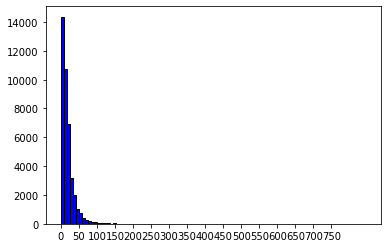

In [ ]:
plt.hist(diagnosis_rnn.tokenized.apply(lambda x: len(x)), color = 'blue', edgecolor = 'black',bins=100)
plt.xticks(np.arange(0, 800,50 ))

In [ ]:
diagnosis_rnn['text_vector']=diagnosis_rnn['tokenized'].progress_apply(lambda x:embedding_layer(x,30)) # vectorize the tokens 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
diagnosis_rnn

,discharge diagnosis:,ICD9_CATEGORY_list,tokenized,target,text_vector
0,osteomyelitis bleeding duodenal ulcer heart fa...,"[250, 585, 584, V58, 458, V13, 403, 362, 707, ...","[osteomyelitis, bleed, duodenal, ulcer, heart,...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[[-0.5143622, -2.4778473, -1.7579305, -3.59031..."
1,"r subdural hematoma, right mca stroke","[440, 250, 285, 278, V58, V85, 996, V45, 272, ...","[r, subdural, hematoma, right, mca, stroke]","[1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[[-1.167836, -1.2357243, -0.3562687, 0.3550909..."
2,type a aortic dissection s/p replacement of as...,"[196, 189, 276, 198, 197]","[type, aortic, dissection, s/p, replacement, a...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-0.9861356, 0.22980636, 1.6956147, 0.1902928..."
3,primary diagnosis s/p pedestrian struck by car...,"[285, 864, E81, 861, 805, 807, 852, 821, 305, ...","[primary, diagnosis, s/p, pedestrian, strike, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[-2.0187273, -1.7896893, 0.19029288, -0.09216..."
4,atrial fibrillation with rapid ventricular res...,"[251, 458, 478, 345, 507, 758, 255, 518, V44, ...","[atrial, fibrillation, rapid, ventricular, res...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[[-2.551801, 0.17634687, -1.7877394, -0.334953..."
...,...,...,...,...,...
40473,s/p motor vehicle crash injuries: multiple lef...,"[E81, 805, 807, 808, 518, 860, 919]","[s/p, motor, vehicle, crash, injury, multiple,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[[0.19029288, 0.7933673, 0.7374813, 0.24634093..."
40474,1. rectal cancer. 2. status post proctocolecto...,"[560, 998, 272, E87, 038, 707, 154, 997, 567]","[1., rectal, cancer, 2., status, post, proctoc...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-0.3615369, -0.7157543, -1.8456633, -0.53597..."
40475,junctional bradycardia chronic diastolic conge...,"[285, 584, 112, 276, 053, 507, 327, 244, E93, ...","[junctional, bradycardia, chronic, diastolic, ...","[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[-0.37994704, -0.6421765, -1.2401546, -0.5545..."
40476,deceased. gastrointestinal stromal tumor. fulm...,"[440, 443, 272, V45, E87, 429, 518, 997, 788, ...","[decease, gastrointestinal, stromal, tumor, fu...","[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","[[-0.09104318, -1.0635493, -0.122941054, -0.26..."


In [ ]:
class rnndataset(Dataset):
  def __init__(self):
    self.nsamples=diagnosis_rnn.shape[0]  

  def __getitem__(self,index):
    x=torch.from_numpy(diagnosis_rnn.iloc[index,4])
    x=x.permute(1,0)
    y=torch.from_numpy(diagnosis_rnn.iloc[index,3])
    return x,y

  def __len__(self):
    return self.nsamples

In [ ]:
dataset_rnn=rnndataset()

In [ ]:
x,y=dataset_rnn[0]
print(x.shape,y.shape)

torch.Size([30, 100]) torch.Size([10])


In [ ]:
def split_indices(n,fraction_train):
  n_train=int(n*fraction_train)
  n_remain=n-n_train
  idxs=np.random.permutation(n)
  n_test=int(n_remain/3)
  return idxs[:n_train],idxs[n_train:n_train+n_test],idxs[n_train+n_test:n_train+n_test*2],idxs[n_train+n_test*2:]


In [ ]:
train_indices,test1_indices,test2_indices,test3_indices=split_indices(len(dataset_rnn),0.5)

In [ ]:
batch_size=128
train_sampler=SubsetRandomSampler(train_indices)

In [ ]:
rnn_train_loader=DataLoader(dataset_rnn,batch_size,sampler=train_sampler)

In [ ]:
# class wordBiRNN(nn.Module):
#   def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(BiRNN, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers

#         # layers of nn
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

#         self.fc = nn.Linear(hidden_size*2, num_classes)  
             
#         # activation
#         self.act = nn.Sigmoid()


#         def forward(self, x):
#           h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
#           c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
      
#           # Forward propagate LSTM
#           out, _ = self.lstm(x, (h0, c0))  
#           out = self.fc(out[:, -1, :])

#           out=self.act(out)
#           return out
          
    
       
        

In [ ]:
class wordRNN(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers,num_classes=10):
    super().__init__()
    self.num_layers=num_layers
    self.hidden_size=hidden_size
    self.rnn = nn.RNN(input_size,hidden_size,num_layers,batch_first=True)
    #x-->(batch_size,seq,input_size)
    self.fc=nn.Linear(hidden_size,num_classes)
    self.act=nn.Sigmoid()

  def forward(self,x):
    h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)

    out,_=self.rnn(x,h0)
    #batch_size,seq_length,hidden_size
    out=out[:,-1,:]
    out=self.fc(out)
    out=self.act(out)
    return out


In [ ]:
# #model = wordBiRNN(input_size, hidden_size, num_layers, num_classes)


# # Loss and optimizer
# criterion = nn.BCELoss()
# optimizer = torch.optim.sgd(model.parameters(), lr=learning_rate)

In [ ]:
input_size=100
hidden_size=100
num_layers=2

In [ ]:
rnnmodel=wordRNN(input_size,hidden_size,num_layers).to(device)

In [ ]:
def multi_acc(y_pred, y_test,threshold=0.5):
  num_classes=y_pred.shape[1]
  y_pred_tags = (y_pred>0.5).float()

  correct_pred = (y_pred_tags == y_test).float()
  accuracy = (correct_pred.sum(dim=1) == num_classes).float().sum() / len(correct_pred)
  return accuracy

In [ ]:
def fit(epochs,model,train_loader,opt_fn,loss_fn):

  for epoch in range(1,epochs+1):

    train_epoch_loss=0
    train_epoch_accuracy=0

    for x,y in train_loader:

      x=x.to(device)
      y=y.to(device)

      opt_fn.zero_grad()

      preds=model(x)

      

      loss=loss_fn(preds,y)
      accuracy= multi_acc(preds,y)

      loss.backward()
      opt_fn.step()
      

      train_epoch_loss+=loss.item()
      train_epoch_accuracy+=accuracy.item()
      

    if epoch%5==0:
      print('Epoch = {}/{}, loss = {:.4f}, accuracy = {:.4f}'.format(epoch
                                                               ,epochs
                                                               ,train_epoch_loss/len(train_loader)
                                                               ,train_epoch_accuracy/len(train_loader)
                                                               ))
    

In [ ]:
learning_rate=1e-3
loss_fn=nn.BCELoss()
opt_fn=torch.optim.Adam(rnnmodel.parameters(), lr=learning_rate)


In [ ]:
rnnmodel.train()
fit(300,rnnmodel,rnn_train_loader,opt_fn,loss_fn)

Epoch = 5/300, loss = 0.5885, accuracy = 0.1437
Epoch = 10/300, loss = 0.5831, accuracy = 0.1417
Epoch = 15/300, loss = 0.5756, accuracy = 0.1424
Epoch = 20/300, loss = 0.5643, accuracy = 0.1452
Epoch = 25/300, loss = 0.5519, accuracy = 0.1505
Epoch = 30/300, loss = 0.5367, accuracy = 0.1579
Epoch = 35/300, loss = 0.5236, accuracy = 0.1680
Epoch = 40/300, loss = 0.5116, accuracy = 0.1714
Epoch = 45/300, loss = 0.5016, accuracy = 0.1795
Epoch = 50/300, loss = 0.4947, accuracy = 0.1813
Epoch = 55/300, loss = 0.4927, accuracy = 0.1837
Epoch = 60/300, loss = 0.4815, accuracy = 0.1893
Epoch = 65/300, loss = 0.4737, accuracy = 0.1974
Epoch = 70/300, loss = 0.4692, accuracy = 0.2016
Epoch = 75/300, loss = 0.4699, accuracy = 0.1955
Epoch = 80/300, loss = 0.4586, accuracy = 0.2076
Epoch = 85/300, loss = 0.4565, accuracy = 0.2069
Epoch = 90/300, loss = 0.4512, accuracy = 0.2075
Epoch = 95/300, loss = 0.4484, accuracy = 0.2084
Epoch = 100/300, loss = 0.4469, accuracy = 0.2096
Epoch = 105/300, los

In [ ]:
rnn_test1_loader=DataLoader(dataset_rnn,batch_size,sampler=test1_sampler)

In [ ]:
rnnmodel.eval()
with torch.no_grad():
  model_result = []
  targets = []
  for x_test, batch_targets in rnn_test1_loader:
    x_test = x_test.to(device)
    model_batch_result = rnnmodel(x_test)
    model_result.extend(model_batch_result.cpu().numpy())
    targets.extend(batch_targets.cpu().numpy())
    result = calculate_metrics(np.array(model_result), np.array(targets))
    print("micro f1: {:.3f} macro f1: {:.3f} samples f1: {:.3f}".format(result['micro/f1'],result['macro/f1'],result['samples/f1']))